In [91]:
#import excel file

import pandas as pd

sku_df = pd.read_excel('/Users/revatirameshkharate/Desktop/ITP Projects/Diggs BI/Diggs SKU Mapping.xlsx', sheet_name='Sheet1')

sku_df=sku_df.drop(['Is Bundle?','Component 1','Component 2','Component 3','Component 4'], axis = 1)
sku_df.rename(columns = {'Diggs SKU':'code'}, inplace = True)

sku_df.head()


,code,Product Title,Variant,Category,Color,Size,Prod_variant
0,WSC007AALW,Collar,Collar - Large - Ash,Walk,Ash,Large,Collar- Ash-Large
1,WSC012AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,Collar- Blush-Large
2,WSC040AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,Collar- Blush-Large
3,WSC008AALB,Collar,Collar - Large - Charcoal,Walk,Charcoal,Large,Collar- Charcoal-Large
4,WSC016AALL,Collar,Collar - Large - Lilac,Walk,Lilac,Large,Collar- Lilac-Large


In [93]:
#importing Inventory products data 

import requests

import json

url = "https://api.cin7.com/api/v1/Products"
query_params = {
    "rows": 250,
    #"where": "createdDate<2023-03-05T00:00:00Z and createdDate>2022-12-31T23:59:59Z",
    #"where": "createdDate BETWEEN '2022-12-31T23:59:59Z' AND '2023-03-01T00:00:00Z'",
    "fields": "productOptions"
    #"fields": "StyleCode, productOptions"
}

headers = {
    "Content-Type": "application/json"
}

auth = ("DiggsIncUS", "9901f725991a42c4b8ea12917e3c21d9")  # replace with your Cin7 username and password

data = []
page = 1
while True:
    query_params["page"] = page
    response = requests.get(url, headers=headers, params=query_params, auth=auth)
    if response.status_code == 200:
        
        # Append the data from the current page to the list of data
        data += response.json()
        # Check if there are more pages of data to fetch
        if len(response.json()) < 250:
            break
        else:
            page += 1
    else:
        print(f"Request failed with status code {response.status_code}")
        break

df = pd.json_normalize(data)

df.head()

,productOptions
0,"[{'id': 967, 'createdDate': '2023-02-23T17:06:..."
1,"[{'id': 966, 'createdDate': '2023-02-23T17:05:..."
2,"[{'id': 965, 'createdDate': '2023-02-23T17:03:..."
3,"[{'id': 964, 'createdDate': '2023-02-23T17:02:..."
4,"[{'id': 963, 'createdDate': '2023-02-23T16:57:..."


In [94]:
df = df.explode('productOptions')

# Use json_normalize to flatten the 'lineItems' column
df_product_options = pd.json_normalize(df['productOptions'])

# Apply function to rename columns
df_product_options = df_product_options.rename(columns=lambda x: x.split(".")[-1])

df.head(4)

,productOptions
0,"{'id': 967, 'createdDate': '2023-02-23T17:06:3..."
1,"{'id': 966, 'createdDate': '2023-02-23T17:05:2..."
2,"{'id': 965, 'createdDate': '2023-02-23T17:03:5..."
3,"{'id': 964, 'createdDate': '2023-02-23T17:02:3..."


In [95]:
df = df.reset_index(drop=True)
# Combine the flattened 'productOptions' DataFrame with the original DataFrame
df_data = pd.concat([df, df_product_options], axis=1)


# Drop the original 'lineItems' column
df_data = df_data.drop('productOptions', axis=1)
df_data.head(2).sort_values(by=['createdDate'])

,id,createdDate,modifiedDate,status,productId,code,barcode,productOptionCode,productOptionSizeCode,productOptionBarcode,...,specialsStartDate,specialDays,stockAvailable,stockOnHand,image,retailUSD,vipusd,wholesaleUSD,costUSD,specialPrice
1,966,2023-02-23T17:05:23Z,2023-02-23T17:05:23Z,Active,1005,MCP001A40G,,MCP001A40G,None,,...,None,0,0.0,0.0,None,0.0,0.0,0.0,11.85,0.0
0,967,2023-02-23T17:06:32Z,2023-02-23T17:06:32Z,Active,1006,MCP001A42G,,MCP001A42G,None,,...,None,0,0.0,0.0,None,0.0,0.0,0.0,16.30,0.0


In [96]:
df_data.dtypes

df_data = df_data.drop(['modifiedDate', 'productOptionCode', 'productOptionSizeCode',
       'productOptionBarcode', 'barcode', 'supplierCode', 'productOptionSizeBarcode','optionWeight', 'size', 
        'retailPrice',
       'wholesalePrice', 'vipPrice', 'specialPrice', 'specialsStartDate',
       'specialDays',  'image', 'retailUSD',
       'vipusd', 'wholesaleUSD', 'costUSD', 'specialPrice'], axis=1)

df_data.head(3)

,id,createdDate,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand
0,967,2023-02-23T17:06:32Z,Active,1006,MCP001A42G,grey,XL,,0.0,0.0
1,966,2023-02-23T17:05:23Z,Active,1005,MCP001A40G,grey,Lg,,0.0,0.0
2,965,2023-02-23T17:03:52Z,Active,1004,MCP001A36G,grey,Int,,0.0,0.0


###### Now we have to dataframes: 
                    Inventory-df_data 
                    SKU mapping - sku_mapping_df

In [97]:
stock_data = pd.merge(df_data, sku_df, on='code')
stock_data.head(3)
#stock_data.dtypes

,id,createdDate,status,productId,code,option1,option2,option3,stockAvailable,stockOnHand,Product Title,Variant,Category,Color,Size,Prod_variant
0,940,2022-11-14T22:04:31Z,Active,979,TPD001AOSC,,,,0.0,0.0,Passenger,Passenger/Pee Pad Bundle - Charcoal,Travel,Charcoal,NaN,Passenger- Charcoal-
1,939,2022-11-14T21:59:15Z,Active,978,WBD001AA4I,,,,0.0,0.0,Poop Bags,Poop Bags 4x Bundle,Walk,NaN,NaN,Poop Bags--
2,938,2022-11-14T21:58:57Z,Active,977,WBD001AA2I,,,,0.0,0.0,Poop Bags,Poop Bags 2x Bundle,Walk,NaN,NaN,Poop Bags--


stock_data.dtypes 
id                  int64
createdDate        object
status             object
productId           int64
code               object
option1            object
option2            object
option3            object
stockAvailable    float64
stockOnHand       float64
Product Title      object
Variant            object
Category           object
Color              object
Size               object
Prod_variant       object
dtype: object

In [98]:
# filter data for a specific date range
#start_date = '2022-11-01'
#end_date = '2023-03-01'
#filtered_stock_data = stock_data[(stock_data['createdDate'] >= start_date) & (stock_data['createdDate'] <= end_date)]

#filtered_
#stock_data.head()

In [99]:
# group by products sold high level view

summarized_df = pd.DataFrame(stock_data.groupby(['Product Title']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_df = summarized_df.sort_values(by='stockAvailable', ascending=False)

summarized_df.head()

,Product Title,stockAvailable
5,Groov,48032.0
13,Revol,21769.0
3,Collar,21765.0
7,Leash,21019.0
4,Dispenser,12603.0


In [100]:
# group by products variant

summarized_df = pd.DataFrame(stock_data.groupby(['Product Title', 'Prod_variant']).agg({'stockAvailable': 'sum'}).reset_index())

summarized_df = summarized_df.sort_values(by='stockAvailable', ascending=False)

summarized_df.head(5)

,Product Title,Prod_variant,stockAvailable
46,Groov,Groov- Blush-,16518.0
49,Groov,Groov- Navy-,12567.0
51,Groov,Groov- Turquoise-,10672.0
87,Poop Bags,Poop Bags--,10208.0
48,Groov,Groov- Lilac-,3921.0


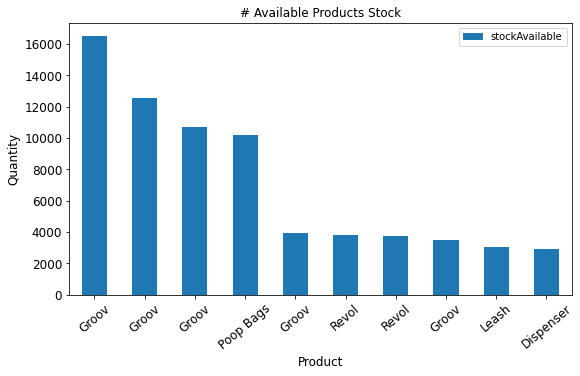

In [101]:
import matplotlib.pyplot as plt

fig1 = summarized_df.head(10).plot(kind = 'bar', x= 'Product Title' , y ='stockAvailable', title ="# Available Products Stock", figsize=(9, 5), legend=True, fontsize=12)

fig1.set_xlabel("Product", fontsize=12)
fig1.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()

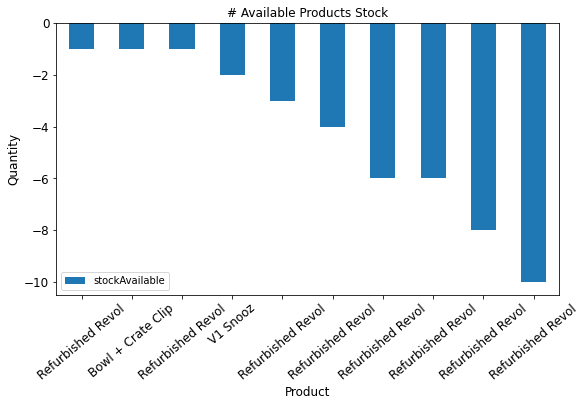

In [102]:

fig2 = summarized_df.tail(10).plot(kind = 'bar', x= 'Product Title' , y ='stockAvailable', title ="# Available Products Stock", figsize=(9, 5), legend=True, fontsize=12)

fig2.set_xlabel("Product", fontsize=12)
fig2.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=40)
plt.show()

In [103]:
no_stock_avail_df = summarized_df[summarized_df["stockAvailable"] == 0]
print(no_stock_avail_df) #products which have no inventory

         Product Title                    Prod_variant  stockAvailable
110        Revol/Snooz          Revol/Snooz- Ash-Large             0.0
7    Bowl + Crate Clip  Bowl + Crate Clip-Charcoal-S/M             0.0
114        Revol/Snooz         Revol/Snooz- Grey-Large             0.0
81           Passenger               Passenger- Slate-             0.0
6    Bowl + Crate Clip  Bowl + Crate Clip-Charcoal-I/L             0.0
4    Bowl + Crate Clip       Bowl + Crate Clip-Ash-I/L             0.0
127           V1 Snooz     V1 Snooz- Light Grey-Medium             0.0
129           V1 Snooz            V1 Snooz- Tan-Medium             0.0
115        Revol/Snooz        Revol/Snooz- Grey-Medium             0.0
130           V1 Snooz             V1 Snooz- Tan-Small             0.0
113        Revol/Snooz    Revol/Snooz- Charcoal-Medium             0.0
111        Revol/Snooz         Revol/Snooz- Ash-Medium             0.0
108              Revol              Revol- Pine-Medium             0.0
52    

#### Product Sales

In [87]:

sales_url = "https://api.cin7.com/api/v1/SalesOrders"
query_params = {
    "rows": 250,
    "where": "createdDate<2023-02-01T00:00:00Z and createdDate>2022-12-31T23:59:59Z",
    #"fields": "Reference,createdDate,FirstName, LastName, projectName,total, LineItems"
    "fields": "LineItems"
    #"fields": "total,LineItems"

}

headers = {
    "Content-Type": "application/json"
}

auth = ("DiggsIncUS", "9901f725991a42c4b8ea12917e3c21d9")  # replace with your Cin7 username and password

data = []
page = 1
while True:
    query_params["page"] = page
    response = requests.get(sales_url, headers=headers, params=query_params, auth=auth)
    if response.status_code == 200:
        
        # Append the data from the current page to the list of data
        data += response.json()
        # Check if there are more pages of data to fetch
        if len(response.json()) < 250:
            break
        else:
            page += 1
    else:
        print(f"Request failed with status code {response.status_code}")
        break

df_prodsales = pd.json_normalize(data)

In [88]:
df_prodsales.head(3)

,lineItems
0,"[{'id': 173662, 'createdDate': '2023-01-31T23:..."
1,"[{'id': 173664, 'createdDate': '2023-01-31T23:..."
2,"[{'id': 173681, 'createdDate': '2023-01-31T23:..."


In [89]:
df_prodsales = df_prodsales.explode('lineItems')

# Use json_normalize to flatten the 'lineItems' column
df_prodsales_line_items = pd.json_normalize(df_prodsales['lineItems'])

# Apply function to rename columns
df_prodsales_line_items = df_prodsales_line_items.rename(columns=lambda x: x.split(".")[-1])

df_prodsales.head()

,lineItems
0,"{'id': 173662, 'createdDate': '2023-01-31T23:5..."
1,"{'id': 173664, 'createdDate': '2023-01-31T23:5..."
1,"{'id': 173665, 'createdDate': '2023-01-31T23:5..."
1,"{'id': 173666, 'createdDate': '2023-01-31T23:5..."
1,"{'id': 173667, 'createdDate': '2023-01-31T23:5..."


In [90]:
df_prodsales = df_prodsales.reset_index(drop=True)

df_prodsales = df_prodsales_line_items

# Remove unwanted columns
df_prodsales = df_prodsales.drop(['parentId', 'productOptionId', 'integrationRef', 'sort', 'sizeCodes', 
                                  'lineComments', 'barcode','holdingQty', 'accountCode', 'stockControl', 'stockMovements'], 
                                 axis=1)


In [91]:
# rename the columns
df_prodsales = df_prodsales.rename(columns={'createdDate': 'SalesOrder_createdDate',
                        'reference': 'SalesOrder_reference',
                        'firstName': 'SalesOrder_firstName',
                        'lastName': 'SalesOrder_lastName',
                        'projectName': 'SalesOrder_projectName',
                        'total': 'SalesOrder_total'})
df_prodsales.head(3)
#raw data ready!

,id,SalesOrder_createdDate,transactionId,productId,code,name,option1,option2,option3,qty,styleCode,unitCost,unitPrice,discount,qtyShipped
0,173662,2023-01-31T23:57:15Z,78808,172,TRV001AOSG,Passenger Travel Carrier - Slate,Grey,OS,,1.0,TRV001AOSG,42.9700,185.25,0.0,1.0
1,173664,2023-01-31T23:56:06Z,78809,165,PAD018AALG,Snooz - L / Grey,Grey,L,,1.0,PAD018AALG,41.4259,150.00,15.0,1.0
2,173665,2023-01-31T23:56:06Z,78809,192,GRO010AASIR,Groov - Ice,Ice,OS,,1.0,GRO010AASIR,3.3760,34.00,3.4,1.0


Merging df_prodsales and sku_mapping_df

In [100]:
sku_mapping_df = pd.read_excel('/Users/revatirameshkharate/Desktop/ITP Projects/Diggs BI/Diggs SKU Mapping.xlsx', sheet_name='Sheet1')

sku_mapping_df=sku_mapping_df.drop(['Is Bundle?','Component 1','Component 2','Component 3','Component 4'], axis = 1)
sku_mapping_df.rename(columns = {'Diggs SKU':'code'}, inplace = True)

sku_mapping_df.head()

,code,Product Title,Variant,Category,Color,Size,Prod_variant
0,WSC007AALW,Collar,Collar - Large - Ash,Walk,Ash,Large,Collar- Ash-Large
1,WSC012AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,Collar- Blush-Large
2,WSC040AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,Collar- Blush-Large
3,WSC008AALB,Collar,Collar - Large - Charcoal,Walk,Charcoal,Large,Collar- Charcoal-Large
4,WSC016AALL,Collar,Collar - Large - Lilac,Walk,Lilac,Large,Collar- Lilac-Large


In [101]:
master_data = pd.merge(df_prodsales, sku_mapping_df, on='code')
master_data.head(2)

,id,SalesOrder_createdDate,transactionId,productId,code,name,option1,option2,option3,qty,...,unitCost,unitPrice,discount,qtyShipped,Product Title,Variant,Category,Color,Size,Prod_variant
0,173662,2023-01-31T23:57:15Z,78808,172,TRV001AOSG,Passenger Travel Carrier - Slate,Grey,OS,,1.0,...,42.9700,185.25,0.0,1.0,Passenger,Passenger - Grey,Travel,Grey,NaN,Passenger- Grey-
1,173664,2023-01-31T23:56:06Z,78809,165,PAD018AALG,Snooz - L / Grey,Grey,L,,1.0,...,41.4259,150.00,15.0,1.0,Snooz,Snooz - Large - Light Grey,Bedding,Light Grey,Large,Snooz- Light Grey-Large


Calculating numbers

In [104]:
Summarized_sales_data = master_data.groupby(['Product Title'])['qty'].sum().reset_index()
Summarized_sales_data = Summarized_sales_data.sort_values(by=['qty'], ascending=False)
Summarized_sales_data.head(10)

,Product Title,qty
13,Revol,137.0
5,Groov,75.0
14,Snooz,73.0
15,Spreadable,49.0
11,Poop Bags,37.0
0,Bowl,30.0
2,Bowl Clip,28.0
1,Bowl + Crate Clip,26.0
4,Dispenser,23.0
8,Passenger,16.0


In [105]:
Summarized_sales_data = master_data.groupby(['Prod_variant'])['qty'].sum().reset_index()
Summarized_sales_data = Summarized_sales_data.sort_values(by=['qty'], ascending=False)
Summarized_sales_data.head(10)

,Prod_variant,qty
68,Spreadable--,49.0
45,Poop Bags--,37.0
2,Bowl Clip-Charcoal-,28.0
20,Groov- Lilac-,22.0
52,Revol- Charcoal-Large,20.0
4,Bowl-Ash-S/M,19.0
48,Revol- Ash-Large,18.0
18,Groov- Blush-,18.0
47,Revol- Ash-Intermediate,18.0
1,Bowl + Crate Clip-Ash-S/M,17.0




## do not refer


In [8]:
#importing data 



,total,lineItems
0,204.24,"[{'id': 173662, 'createdDate': '2023-01-31T23:..."
1,836.90,"[{'id': 173664, 'createdDate': '2023-01-31T23:..."
2,195.00,"[{'id': 173681, 'createdDate': '2023-01-31T23:..."


,total,lineItems
0,204.24,"{'id': 173662, 'createdDate': '2023-01-31T23:5..."
1,836.90,"{'id': 173664, 'createdDate': '2023-01-31T23:5..."
1,836.90,"{'id': 173665, 'createdDate': '2023-01-31T23:5..."
1,836.90,"{'id': 173666, 'createdDate': '2023-01-31T23:5..."
1,836.90,"{'id': 173667, 'createdDate': '2023-01-31T23:5..."


,id,createdDate,transactionId,parentId,productId,productOptionId,integrationRef,sort,code,name,...,sizeCodes,lineComments,unitCost,unitPrice,discount,qtyShipped,holdingQty,accountCode,stockControl,stockMovements
0,173662.0,2023-01-31T23:57:15Z,78808.0,0.0,172.0,117.0,0,10.0,TRV001AOSG,Passenger Travel Carrier - Slate,...,NaN,None,42.9700,185.25,0.0,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."
1,173664.0,2023-01-31T23:56:06Z,78809.0,0.0,165.0,98.0,0,10.0,PAD018AALG,Snooz - L / Grey,...,NaN,None,41.4259,150.00,15.0,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."
2,173665.0,2023-01-31T23:56:06Z,78809.0,0.0,192.0,139.0,0,10.0,GRO010AASIR,Groov - Ice,...,NaN,None,3.3760,34.00,3.4,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."
3,173666.0,2023-01-31T23:56:06Z,78809.0,173663.0,906.0,867.0,0,10.0,CRA022AALW-1,Large Revol Crate; Ash; Box 1,...,NaN,None,201.1600,0.00,0.0,1.0,0.0,None,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."
4,173667.0,2023-01-31T23:56:06Z,78809.0,173663.0,909.0,870.0,0,10.0,CRA022AALW-2,Large Revol Crate; Ash; Box 2,...,NaN,None,67.1800,0.00,0.0,1.0,0.0,None,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."


In [12]:
# Drop the original 'lineItems' column
#df_prodsales = df_prodsales.drop('lineItems', axis=1)


,id,SalesOrder_createdDate,transactionId,productId,code,name,option1,option2,option3,qty,styleCode,unitCost,unitPrice,discount,qtyShipped
0,173662.0,2023-01-31T23:57:15Z,78808.0,172.0,TRV001AOSG,Passenger Travel Carrier - Slate,Grey,OS,,1.0,TRV001AOSG,42.9700,185.25,0.0,1.0
1,173664.0,2023-01-31T23:56:06Z,78809.0,165.0,PAD018AALG,Snooz - L / Grey,Grey,L,,1.0,PAD018AALG,41.4259,150.00,15.0,1.0
2,173665.0,2023-01-31T23:56:06Z,78809.0,192.0,GRO010AASIR,Groov - Ice,Ice,OS,,1.0,GRO010AASIR,3.3760,34.00,3.4,1.0


In [24]:
#import excel file

sku_mapping_df = pd.read_excel('/Users/revatirameshkharate/Desktop/ITP Projects/Diggs BI/Diggs SKU Mapping.xlsx', sheet_name='Sheet1')

#sku_mapping_df['Prod_variant'] = sku_mapping_df['Product Title'] +'-'+ sku_mapping_df['Color'] + '-' +sku_mapping_df['Size']
sku_mapping_df.rename(columns = {'Diggs SKU':'styleCode'}, inplace = True)

sku_mapping_df = sku_mapping_df.drop(['Is Bundle?','Component 1','Component 2','Component 3','Component 4'], axis = 1)

sku_mapping_df.head(3)



,styleCode,Product Title,Variant,Category,Color,Size,Prod_variant
0,WSC007AALW,Collar,Collar - Large - Ash,Walk,Ash,Large,Collar- Ash-Large
1,WSC012AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,Collar- Blush-Large
2,WSC040AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,Collar- Blush-Large


In [25]:
#merging dfs

concat_data = pd.merge(df_prodsales, sku_mapping_df, on='styleCode')
concat_data.head(3)

,id,SalesOrder_createdDate,transactionId,productId,code,name,option1,option2,option3,qty,...,unitCost,unitPrice,discount,qtyShipped,Product Title,Variant,Category,Color,Size,Prod_variant
0,173662.0,2023-01-31T23:57:15Z,78808.0,172.0,TRV001AOSG,Passenger Travel Carrier - Slate,Grey,OS,,1.0,...,42.970,185.25,0.00,1.0,Passenger,Passenger - Grey,Travel,Grey,NaN,Passenger- Grey-
1,172811.0,2023-01-30T02:46:05Z,78493.0,172.0,TRV001AOSG,Passenger Travel Carrier - Slate,Grey,OS,,1.0,...,42.970,185.25,0.00,1.0,Passenger,Passenger - Grey,Travel,Grey,NaN,Passenger- Grey-
2,172633.0,2023-01-29T15:48:05Z,78421.0,172.0,TRV001AOSG,Passenger Travel Carrier - Slate,Grey,OS,,1.0,...,56.102,185.25,92.62,1.0,Passenger,Passenger - Grey,Travel,Grey,NaN,Passenger- Grey-


In [26]:
print(concat_data.dtypes)

id                        float64
SalesOrder_createdDate     object
transactionId             float64
productId                 float64
code                       object
name                       object
option1                    object
option2                    object
option3                    object
qty                       float64
styleCode                  object
unitCost                  float64
unitPrice                 float64
discount                  float64
qtyShipped                float64
Product Title              object
Variant                    object
Category                   object
Color                      object
Size                       object
Prod_variant               object
dtype: object


In [27]:
Summarized_concat_data = concat_data.groupby(['Prod_variant'])[['qty','stockAvailable']].sum().reset_index()
Summarized_concat_data = Summarized_concat_data.sort_values(by=['qty', 'stockAvailable'], ascending=False)
Summarized_concat_data.head(10)

KeyError: "Columns not found: 'stockAvailable'"

In [240]:
# group by products sold
#product_sales = df_data.groupby(['styleCode','SalesOrder_reference'])['qty'].sum().sort_values(ascending=False)

#prod_data3 = master_data.groupby(['Prod_variant_y'])[['qty','stockAvailable']].sum()
#prod_data3 = prod_data3.to_frame()
#prod_data3.head(10)
prod_data3 = master_data.groupby(['Prod_variant_y'])[['qty','stockAvailable']].sum().reset_index()
prod_data3 = prod_data3.sort_values(by=['qty', 'stockAvailable'], ascending=False)
prod_data3.head(10)

,Prod_variant_y,qty,stockAvailable
83,Poop Bags--,977.0,3080634.0
49,Groov- Turquoise-,868.0,980863.0
111,Spreadable--,800.0,881430.0
3,Bowl Clip-Charcoal-,612.0,141716.0
44,Groov- Blush-,583.0,1273276.0
90,Revol- Ash-Large,434.0,298812.0
89,Revol- Ash-Intermediate,425.0,240147.0
5,Bowl-Ash-S/M,283.0,174685.0
94,Revol- Charcoal-Large,271.0,94842.0
98,Revol- Grey-Large,269.0,119159.0
